# SETUP
---

## import packages

In [1]:
import pandas as pd
import numpy as np
import time
import glob

from fastparquet import ParquetFile

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import umap

# clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture

print('--- packages imported ---')

--- packages imported ---


## set plot style

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to set plot style if no arguments provided
jtplot.style()

print('--- jtplot.style() initialized    --')
print('--- theme plot style will be used ---')

--- jtplot.style() initialized    --
--- theme plot style will be used ---


## define constants

In [3]:
VERBOSE = True
DEBUG = False
#COLORS = sns.husl_palette(21)
#COLORS = ['r','g','b','y']
COLORS = ["r","g","y","m","w","b","c","limegreen",'tab:orange','tab:pink','tab:cyan','tab:olive','tab:green','tab:blue','tab:red','tab:purple',
         'firebrick','tomato','aqua','dodgerblue','lime']

print('--- constants initialized ---')

--- constants initialized ---


## load dataset

In [4]:
df = pd.read_csv('instacart_order_pivot.csv')
df = df.sort_values(by=['user_id','order_number']).reset_index().drop(['index'], axis=1)
print(df.shape)
df.tail()

(3292455, 30)


,order_id,user_id,eval_set,order_number,order_dow,order_hour,d1,d2,d3,d4,...,d15,d16,d17,d18,d19,d20,d21,days_elapsed,reord1,num_items
3292450,2266710,206209,prior,10,5,18,1,0,1,1,...,0,1,1,0,1,0,0,29.0,3,9
3292451,1854736,206209,prior,11,4,10,0,0,1,1,...,0,2,1,0,1,1,0,30.0,6,8
3292452,626363,206209,prior,12,1,12,0,0,2,5,...,0,4,3,0,1,1,0,18.0,14,20
3292453,2977660,206209,prior,13,1,12,0,0,0,1,...,0,2,0,0,4,0,0,7.0,4,9
3292454,272231,206209,train,14,6,14,1,0,1,1,...,0,1,1,0,1,0,0,30.0,4,8


# FEATURE ENGINEERING
---

## group by user and aggregate

In [5]:
# copy original dataframe
dfgrp = df.copy()

# save off department list for later use
dept_list = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11',
             'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']

# group by user_id and aggregate by sums and means
dfgrp = dfgrp.groupby('user_id').aggregate({
    # item variables
    'd1':'sum', 'd2':'sum', 'd3':'sum',
    'd4':'sum', 'd5':'sum', 'd6':'sum',
    'd7':'sum', 'd8':'sum', 'd9':'sum',
    'd10':'sum', 'd11':'sum', 'd12':'sum',
    'd13':'sum', 'd14':'sum', 'd15':'sum',
    'd16':'sum', 'd17':'sum', 'd18':'sum',
    'd19':'sum', 'd20':'sum', 'd21':'sum',
    'reord1':'mean', 'num_items':'mean',
    # order placement variables (time, day, lag)
    'order_number':'last','order_dow':'mean',
    'order_hour':'mean','days_elapsed':'mean'
}).reset_index()
dfgrp.head()

,user_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d18,d19,d20,d21,reord1,num_items,order_number,order_dow,order_hour,days_elapsed
0,1,0,0,0,5,0,0,15,0,0,...,0,25,0,0,4.636364,6.363636,11,2.636364,10.090909,17.272727
1,2,17,0,2,36,0,3,9,0,0,...,0,42,21,0,6.642857,13.928571,14,2.142857,10.571429,14.142857
2,3,6,0,0,38,0,0,3,0,4,...,0,9,2,0,4.230769,6.769231,13,1.384615,16.307692,11.076923
3,4,3,0,2,2,2,0,3,0,0,...,0,1,2,0,0.166667,3.000000,6,4.500000,12.500000,14.166667
4,5,2,0,0,23,0,4,0,0,1,...,0,1,1,0,3.600000,9.200000,5,1.400000,15.000000,9.200000


## visualize aggregated variables

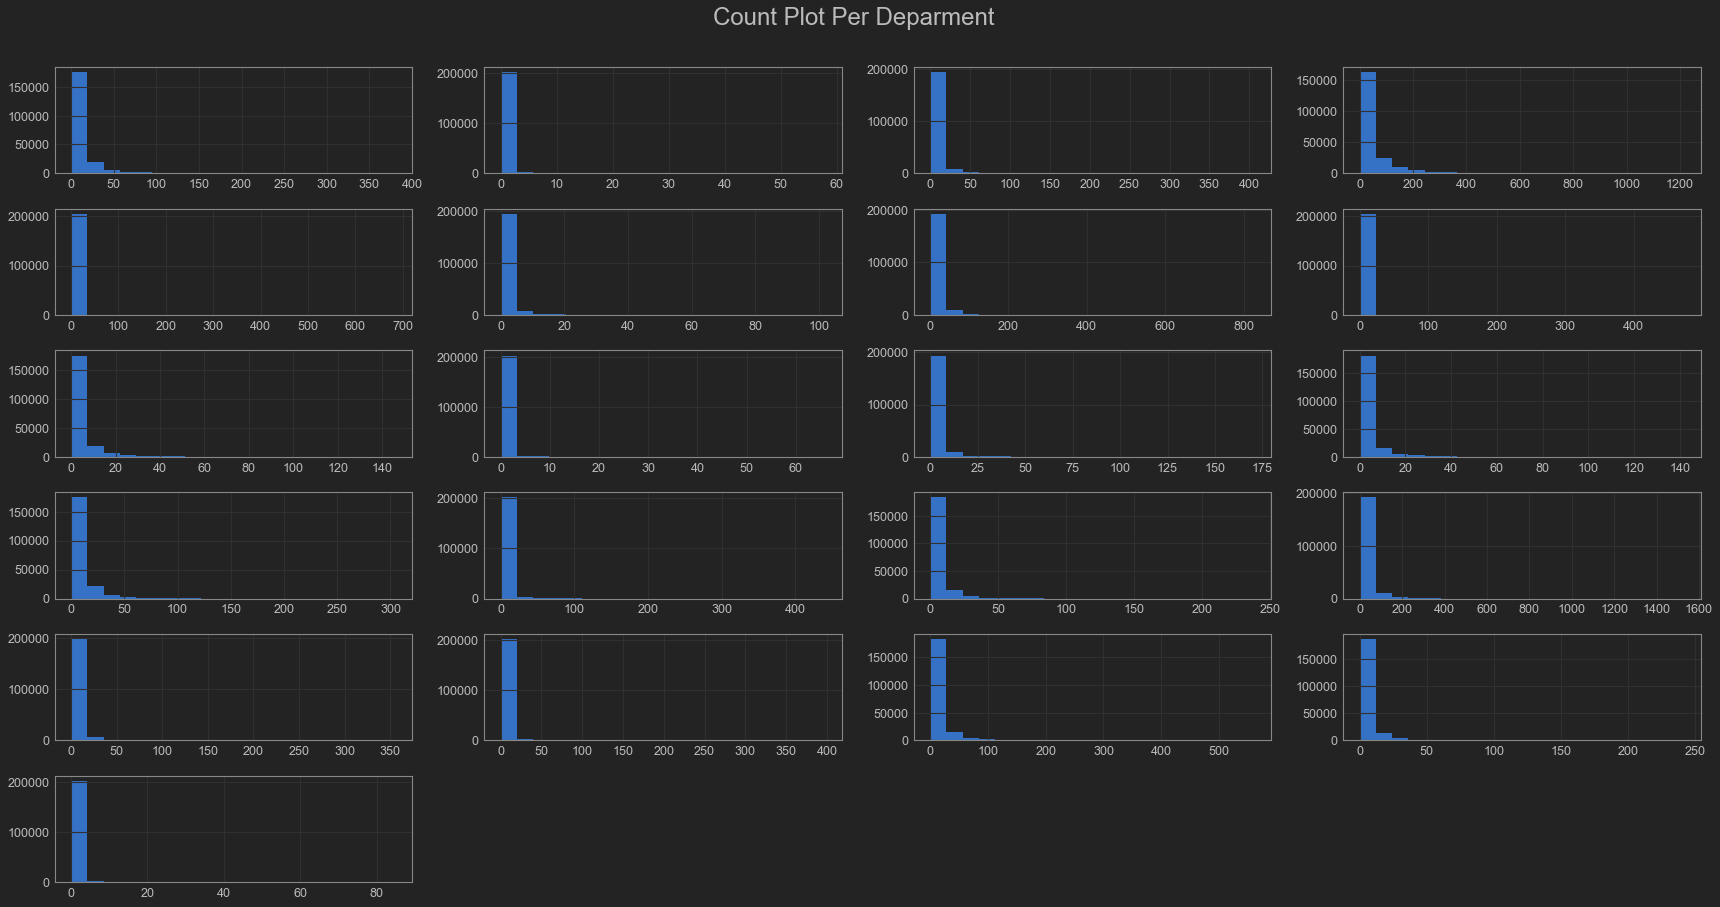

In [6]:
# set figure size
plt.rcParams['figure.figsize'] = (24,12)

# plot histograms
for dept in range(1,22):
    plt.subplot(6,4,dept)
    plt.hist(dfgrp[f'd{dept}'], bins=20)

# plot title
plt.suptitle('Count Plot Per Deparment ', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

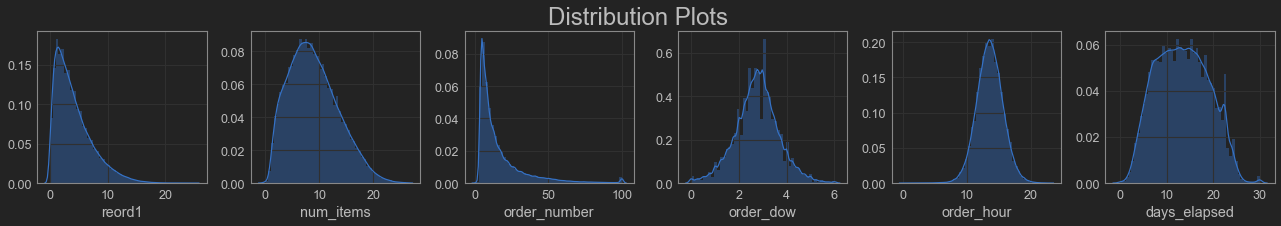

In [7]:
# set figure size
plt.rcParams['figure.figsize'] = (18,3)

# define variables to plot
col_list = ['reord1','num_items','order_number','order_dow','order_hour','days_elapsed']

# plot distribution plot
count = 1
for col in col_list:
    plt.subplot(1,6,count)
    count += 1
    sns.distplot(dfgrp[col])

# plot title
plt.suptitle('Distribution Plots ', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

- several of these variables are heavily skewed, especially order_number and reord1
- to improve normality, we will log transform them

## transform variables

In [8]:
dfgrp['reord1_log1p'] = np.log1p(dfgrp.reord1)
dfgrp['num_items_log1p'] = np.log1p(dfgrp.num_items)
dfgrp['order_number_log1p'] = np.log1p(dfgrp.order_number)
#dfgrp['order_dow_log1p'] = np.log1p(dfgrp.order_dow)
#dfgrp['order_hour_log1p'] = np.log1p(dfgrp.order_hour)
dfgrp['days_elapsed_log1p'] = np.log1p(dfgrp.days_elapsed)

##### note: I used log1p instead of standard log to prevent 0 values from being transformed to infinity, which cannot be plotted or used in clustering analysis

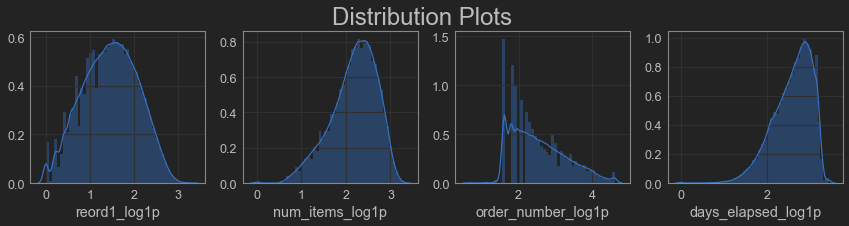

In [9]:
plt.rcParams['figure.figsize'] = (12,3)

col_list = ['reord1_log1p','num_items_log1p','order_number_log1p','days_elapsed_log1p']
count = 1
for col in col_list:
    plt.subplot(1,4,count)
    count += 1
    sns.distplot(dfgrp[col])

plt.suptitle('Distribution Plots ', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

# HELPER FUNCTIONS
---

## plotting functions

In [10]:
# umap dimensionality reduction
def run_umap(X, neighbors=5, dist=0.1):
    time_start = time.time()
    print('UMAP start...')
    umap_results = umap.UMAP(n_neighbors=neighbors, min_dist=dist, metric='correlation').fit_transform(X)
    print(f'UMAP completed in {(time.time()-time_start):.6f} seconds!\n')
    return umap_results

print('--- run_umap() defined ---')

# pca dimensionality reduction
def run_pca(X):
    time_start = time.time()
    print('PCA start...')
    pca = PCA(n_components=2).fit_transform(X)
    print(f'PCA completed in {(time.time()-time_start):.6f} seconds!\n')
    return pca

print('--- run_pca() function defined ---')

--- run_umap() defined ---
--- run_pca() function defined ---


In [11]:
def plot_elbow_method(inertia, k_range=range(2,11)):
    print('--- plot_elbow_method() ---')
    time_start = time.time()
    
    # set figure size
    plt.rcParams['figure.figsize'] = (8,4)

    # plot points
    plt.plot(k_range , inertia , 'o')
    plt.plot(k_range , inertia , '-' , alpha = 0.5)

    # plot labels
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Choosing k\nElbow Method', fontsize=20)

    plt.tight_layout()
    plt.show()
    print(f'--- plot_elbow_method() completed in {time.time()-time_start:.4f} seconds')
    
print('--- plot_elbow_method() function defined ---')

--- plot_elbow_method() function defined ---


In [12]:
def plot_2D(data, y=None):
    print(f'--- plot_2D() ---')
    time_start = time.time()
    
    colors = COLORS
    
    # plot data points with color grouping
    if y is not None:
        df_tmp = pd.concat([pd.DataFrame(data),pd.DataFrame(y)], axis=1)
        df_tmp.columns = ['x','y','cluster']
        
        if DEBUG:
            print(df_tmp.cluster.unique())
        
        for i in df_tmp.cluster.unique():
            plt.scatter(df_tmp[df_tmp.cluster == i].x, df_tmp[df_tmp.cluster == i].y, color = colors[i])
            
    # plot data points without color grouping
    else:
        plt.scatter(data[:, 0], data[:, 1])

    # disable axes
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    print(f'--- plot_2D() completed in {(time.time()-time_start):.6f} seconds! ---')

print('--- plot_2D() function defined --- ')

--- plot_2D() function defined --- 


In [13]:
def silhouette_plot(cluster_labels, x, k):
    print(f'--- silhouette_plot() ---')
    func_start = time.time()
    
    if VERBOSE:
        print(f'\t--- cluster_solution = {set(list(cluster_labels))}')

    # calculate silhouette average across all samples
    silhouette_avg = silhouette_score(x, cluster_labels)
    print(f'\t--- calculated silhouette average across all samples ({silhouette_avg:.6f}) in {time.time()-func_start:.4f} seconds ---')
    time_start = time.time()
    
    # calculate silhouette score for each sample
    silhouette_sam = silhouette_samples(x, cluster_labels)
    print(f'\t--- calculated silhouette score for each sample in {time.time()-time_start:.4f} seconds ---')
    
    y_lower = 10
    
    # iterate through each cluster
    for i in range(k):
        loop_start = time.time()

        # select the samples for each cluster i
        cluster_silhouette_vals = silhouette_sam[cluster_labels == i]
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: select the samples for cluster {i} ---')
        
        # sort the cluster's per-sample silhouette coefficients
        cluster_silhouette_vals.sort()
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: sort the clusters per-sample silhouette coefficients for cluster {i} ---')
        
        # define cluster size (for plotting)
        cluster_size = cluster_silhouette_vals.shape[0]

        y_upper = y_lower + cluster_size
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: define cluster size for cluster {i} ---')
        
        # define color for then plot each cluster
        color = COLORS[i]
        
        # plot silhouette coefficient values
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: plotting silhouette plot for cluster {i} ---')
        
        # label cluster at the y-midpoint of the cluster
        plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
        
        # compute y_lower for next cluster
        y_lower = y_upper + 10
        
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: cluster {k} ---')
            
    # plot silhouette average as a vertical line
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # plot labeling options
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster Label')
    plt.xticks(np.arange(-0.5, 0.7, 0.1))
    plt.yticks([])
    plt.title(f'Silhouette Plot for {k} Clusters')
    
    print(f'--- silhouette_plot() completed in {time.time()-func_start:.4f} seconds ---')
    
print('--- silhouette_plot() function defined ---')

--- silhouette_plot() function defined ---


## cluster analysis functions

In [14]:
def elbow_method(x, k_range=range(2,11), mini=False):
    print('--- elbow_method() ---')
    func_start = time.time()
    
    inertia = []
    for k in k_range:
        time_start = time.time()
        if mini:
            kmeans_ = MiniBatchKMeans(n_clusters=k).fit(x)
        else:
            kmeans_ = KMeans(n_clusters=k).fit(x)
        inertia.append(kmeans_.inertia_)
        if VERBOSE:
            print(f'\t--- {time.time()-time_start:.2f} seconds: k={k} ---')
    
    print(f'--- elbow_method() completed in {time.time()-func_start:.4f} seconds ---')
        
    return inertia

print('--- elbow_method() function defined ---')

--- elbow_method() function defined ---


In [15]:
def silhouette_analysis(x, cluster_range=range(3,6), algo='KMEANS', reduced_results=None, dbscan_eps=1.1, dbscan_min_samples=10, dbscan_clusters=2):
    print('--- silhouette_analysis() ---')
    func_start = time.time()
    
    # set figure size
    plt.rcParams['figure.figsize'] = (16,16)

    # define cluster range
    if algo == 'DBSCAN':
        clusters = range(dbscan_clusters,dbscan_clusters+1)
    else:
        clusters = cluster_range

    count = 1
    # try multiple num cluster values
    for k in clusters:
        loop_start_ = time.time()
        
        # select clusterer
        if algo == 'GMM':
            clusterer = GaussianMixture(n_components=k)
        elif algo == 'AGGLOMERATIVE-1':
            clusterer = AgglomerativeClustering(linkage='complete', affinity='cosine', n_clusters=k)
        elif algo == 'AGGLOMERATIVE-2':
            clusterer = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=k)
        elif algo == 'AGGLOMERATIVE-3':
            clusterer = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=k)
        elif algo == 'AGGLOMERATIVE-4':
            clusterer = AgglomerativeClustering(linkage='average', affinity='euclidean', n_clusters=k)
        elif algo == 'DBSCAN':
            clusterer = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
        elif algo =='MINIBATCHKMEANS':
            clusterer = MiniBatchKMeans(n_clusters=k)
        else:
            clusterer = KMeans(n_clusters=k, n_jobs=4)
        
        # get cluster labels
        cluster_labels = clusterer.fit_predict(x)

        # silhouette plot
        plt.subplot(5,2,count)
        silhouette_plot(cluster_labels, x, k)
        count += 1

        # cluster plots
        plt.subplot(5,2,count)
        plot_2D(reduced_results, cluster_labels)
        count += 1
        
        if VERBOSE:
            print(f'\t--- {k}-cluster silhouette analysis completed in {time.time()-loop_start_:.4f} seconds ---')
    
    plt.suptitle(f'Silhouette Analysis with {algo} Clusterer', y=1.05, fontsize=20)
    plt.tight_layout()
    plt.show()
    print(f'--- silhouette analysis() completed in {time.time()-func_start:.4f} seconds ---')
    
print('--- silhouette_analysis function defined ---')

--- silhouette_analysis function defined ---


# CLUSTERING
---

## define model

In [16]:
dfgrp.head()

,user_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,reord1,num_items,order_number,order_dow,order_hour,days_elapsed,reord1_log1p,num_items_log1p,order_number_log1p,days_elapsed_log1p
0,1,0,0,0,5,0,0,15,0,0,...,4.636364,6.363636,11,2.636364,10.090909,17.272727,1.729239,1.996554,2.484907,2.905410
1,2,17,0,2,36,0,3,9,0,0,...,6.642857,13.928571,14,2.142857,10.571429,14.142857,2.033772,2.703277,2.708050,2.717529
2,3,6,0,0,38,0,0,3,0,4,...,4.230769,6.769231,13,1.384615,16.307692,11.076923,1.654558,2.050171,2.639057,2.491296
3,4,3,0,2,2,2,0,3,0,0,...,0.166667,3.000000,6,4.500000,12.500000,14.166667,0.154151,1.386294,1.945910,2.719100
4,5,2,0,0,23,0,4,0,0,1,...,3.600000,9.200000,5,1.400000,15.000000,9.200000,1.526056,2.322388,1.791759,2.322388


### feature selection

In [17]:
# copy dataframe
df_model = dfgrp.copy()
df_model_bkup = df_model.copy()

# drop user_id
df_model = df_model.drop(['user_id'], axis=1)

# drop original versions of transformed variables
df_model = df_model.drop(['reord1','num_items','order_number','order_dow','order_hour','days_elapsed'], axis=1)

# drop selected deparments (to be PCA'd separately)
df_model = df_model.drop(dept_list, axis=1)

df_model1 = df_model.copy()
df_model2 = df_model.drop(['order_number_log1p','days_elapsed_log1p'], axis=1).copy()

print('\t--- Model Shape(s) ---')
print('\t---',df_model1.shape)
print('\t---',df_model2.shape)

print('\t--- Model(s) ---')
print(df_model1.head())
print(df_model2.head())

	--- Model Shape(s) ---
	--- (206059, 4)
	--- (206059, 2)
	--- Model(s) ---
   reord1_log1p  num_items_log1p  order_number_log1p  days_elapsed_log1p
0      1.729239         1.996554            2.484907            2.905410
1      2.033772         2.703277            2.708050            2.717529
2      1.654558         2.050171            2.639057            2.491296
3      0.154151         1.386294            1.945910            2.719100
4      1.526056         2.322388            1.791759            2.322388
   reord1_log1p  num_items_log1p
0      1.729239         1.996554
1      2.033772         2.703277
2      1.654558         2.050171
3      0.154151         1.386294
4      1.526056         2.322388


### feature transformation

In [18]:
# one-hot encoding
X1 = pd.get_dummies(df_model1, drop_first=True)
X2 = pd.get_dummies(df_model2, drop_first=True)
print(X1.shape)
print(X1.head())
print(X2.shape)
print(X2.head())

(206059, 4)
   reord1_log1p  num_items_log1p  order_number_log1p  days_elapsed_log1p
0      1.729239         1.996554            2.484907            2.905410
1      2.033772         2.703277            2.708050            2.717529
2      1.654558         2.050171            2.639057            2.491296
3      0.154151         1.386294            1.945910            2.719100
4      1.526056         2.322388            1.791759            2.322388
(206059, 2)
   reord1_log1p  num_items_log1p
0      1.729239         1.996554
1      2.033772         2.703277
2      1.654558         2.050171
3      0.154151         1.386294
4      1.526056         2.322388


In [19]:
# standardize variables
scaler = StandardScaler()
X1_std = scaler.fit_transform(X1)
X2_std = scaler.fit_transform(X2)
print(X1_std.shape)
print(X2_std.shape)

(206059, 4)
(206059, 2)


### department dimensionality reduction (pca)

In [20]:
scaler = StandardScaler()
depts = scaler.fit_transform(df_model_bkup.loc[:, 'd1':'d21'])
pca = PCA(n_components=5)
pca_data = pca.fit_transform(depts)

In [21]:
print('% Variance explained by each component',pca.explained_variance_ratio_)
print('% Varaince explained by all components:',f'{sum(pca.explained_variance_ratio_)*100:.2f}%')

% Variance explained by each component [0.30394868 0.07307402 0.0549411  0.04920156 0.04694659]
% Varaince explained by all components: 52.81%


In [22]:
# add pca components
X1_std_orig = X1_std
X2_std_orig = X2_std
X1_std = np.concatenate((X1_std_orig,pca_data),axis=1)
X2_std = np.concatenate((X2_std_orig,pca_data),axis=1)
print(pd.DataFrame(X1_std))
print(pd.DataFrame(X2_std))

               0         1         2         3         4         5         6  \
0       0.442739 -0.355057 -0.093319  0.732979 -1.333129  0.450765 -0.916854   
1       0.931888  1.024833  0.206936  0.314763  0.673699 -0.400510 -1.077385   
2       0.322784 -0.250368  0.114101 -0.188823 -1.222765 -0.279014 -0.123401   
3      -2.087217 -1.546601 -0.818576  0.318260 -1.878756  0.093317  0.027083   
4       0.116380  0.281140 -1.025997 -0.564808 -1.454014 -0.415667  0.427864   
...          ...       ...       ...       ...       ...       ...       ...   
206054  0.081077  0.864262 -1.271323  0.059134 -1.376605 -0.327438 -0.185407   
206055 -0.578087 -1.037645  2.260351 -2.307725  2.441861  1.733203  0.340352   
206056  1.141063  0.915782  0.452262  0.213680  1.191120 -0.788325 -0.065269   
206057  1.373672  0.893623  1.853611 -1.111402  7.458071 -1.442972 -1.319024   
206058  0.444588  0.390158  0.206936  0.717101  0.290148  0.619118 -0.289524   

               7         8  
0      -0.

## elbow method

--- elbow_method() ---
	--- 0.99 seconds: k=2 ---
	--- 0.68 seconds: k=3 ---
	--- 0.65 seconds: k=4 ---
	--- 0.68 seconds: k=5 ---
	--- 0.84 seconds: k=6 ---
	--- 0.76 seconds: k=7 ---
	--- 0.65 seconds: k=8 ---
	--- 0.63 seconds: k=9 ---
	--- 0.61 seconds: k=10 ---
	--- 1.50 seconds: k=11 ---
	--- 1.39 seconds: k=12 ---
	--- 0.74 seconds: k=13 ---
	--- 1.80 seconds: k=14 ---
	--- 0.69 seconds: k=15 ---
	--- 0.80 seconds: k=16 ---
	--- 0.64 seconds: k=17 ---
	--- 0.63 seconds: k=18 ---
	--- 0.64 seconds: k=19 ---
	--- 0.70 seconds: k=20 ---
--- elbow_method() completed in 16.0081 seconds ---
--- plot_elbow_method() ---


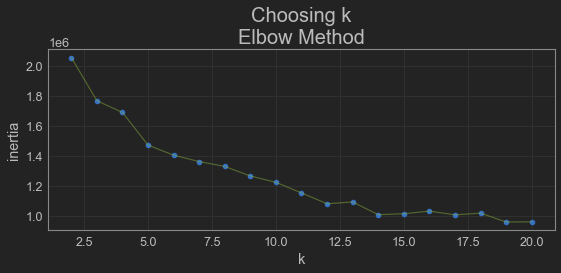

--- plot_elbow_method() completed in 0.1332 seconds


In [23]:
inertia = elbow_method(X1_std, range(2,21), True)
plot_elbow_method(inertia, range(2,21))

--- elbow_method() ---
	--- 3.43 seconds: k=2 ---
	--- 0.69 seconds: k=3 ---
	--- 0.66 seconds: k=4 ---
	--- 0.63 seconds: k=5 ---
	--- 0.68 seconds: k=6 ---
	--- 0.65 seconds: k=7 ---
	--- 0.64 seconds: k=8 ---
	--- 0.66 seconds: k=9 ---
	--- 0.73 seconds: k=10 ---
	--- 0.68 seconds: k=11 ---
	--- 0.70 seconds: k=12 ---
	--- 0.74 seconds: k=13 ---
	--- 0.81 seconds: k=14 ---
	--- 0.72 seconds: k=15 ---
	--- 0.66 seconds: k=16 ---
	--- 2.48 seconds: k=17 ---
	--- 0.71 seconds: k=18 ---
	--- 0.75 seconds: k=19 ---
	--- 0.61 seconds: k=20 ---
--- elbow_method() completed in 17.6194 seconds ---
--- plot_elbow_method() ---


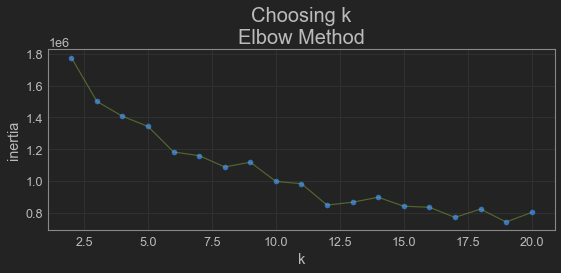

--- plot_elbow_method() completed in 0.1127 seconds


In [24]:
inertia = elbow_method(X2_std, range(2,21), True)
plot_elbow_method(inertia, range(2,21))

## silhouette analysis

In [25]:
# define sampling rate
sampling_rate = 0.15
num_samples = int(X1_std.shape[0] * sampling_rate)
num_samples

30908

In [26]:
# sample the data for silhouette analysis
X1_std_ = X1_std[np.random.choice(X1_std.shape[0], num_samples, replace=False)]
X2_std_ = X2_std[np.random.choice(X2_std.shape[0], num_samples, replace=False)]

# execute pca
pca_results_1 = run_pca(X1_std_)
pca_results_2 = run_pca(X2_std_)

# execute umap
#umap_results_1 = run_umap(X1_std_)
#umap_results_2 = run_umap(X2_std_)

PCA start...
PCA completed in 0.115694 seconds!

PCA start...
PCA completed in 0.065824 seconds!



### kmeans

--- silhouette_analysis() ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3}
	--- calculated silhouette average across all samples (0.180736) in 25.5569 seconds ---
	--- calculated silhouette score for each sample in 19.4073 seconds ---
--- silhouette_plot() completed in 45.0241 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.060838 seconds! ---
	--- 4-cluster silhouette analysis completed in 45.2654 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4}
	--- calculated silhouette average across all samples (0.208737) in 16.8839 seconds ---
	--- calculated silhouette score for each sample in 16.9101 seconds ---
--- silhouette_plot() completed in 33.8224 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.025440 seconds! ---
	--- 5-cluster silhouette analysis completed in 34.0089 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4, 5}
	--- calculated silhouette average across all samples (0.218681) in 20.7

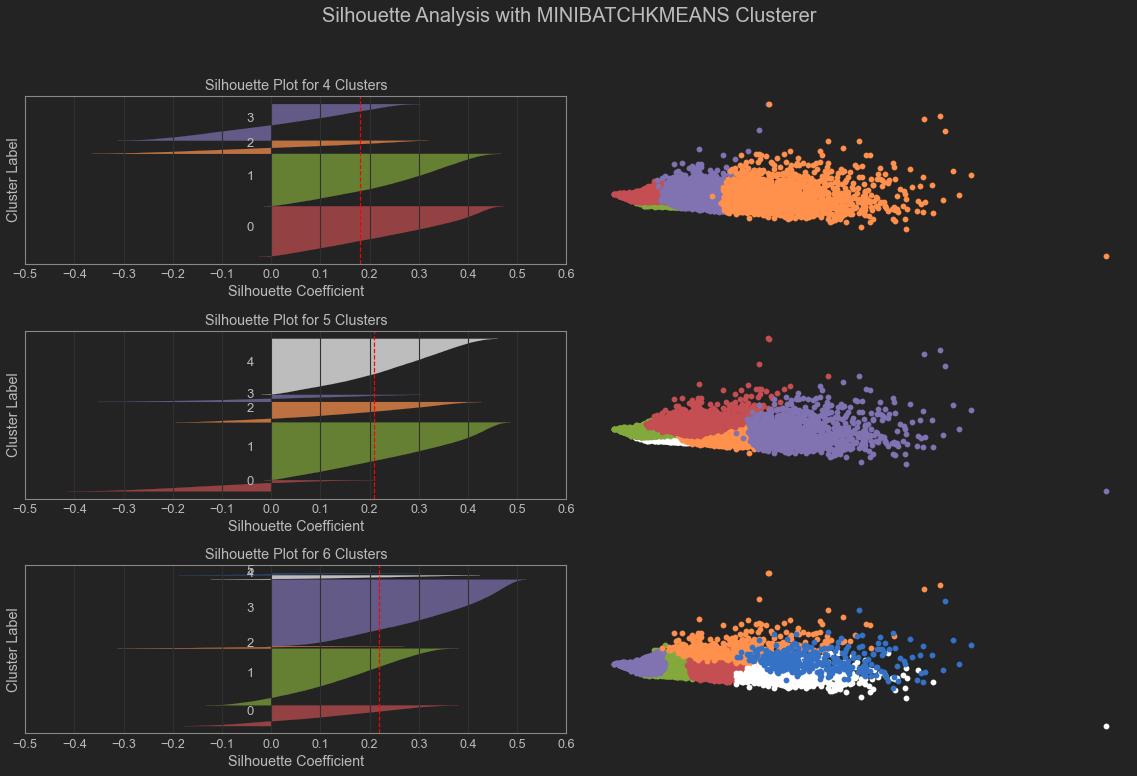

--- silhouette analysis() completed in 119.4459 seconds ---


In [27]:
silhouette_analysis(X1_std_, [4,5,6], 'MINIBATCHKMEANS', pca_results_1)

--- silhouette_analysis() ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2}
	--- calculated silhouette average across all samples (0.281109) in 15.8683 seconds ---
	--- calculated silhouette score for each sample in 16.6891 seconds ---
--- silhouette_plot() completed in 32.5783 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 1.944801 seconds! ---
	--- 3-cluster silhouette analysis completed in 34.6807 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3}
	--- calculated silhouette average across all samples (0.271628) in 16.3173 seconds ---
	--- calculated silhouette score for each sample in 16.1630 seconds ---
--- silhouette_plot() completed in 32.5008 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.021452 seconds! ---
	--- 4-cluster silhouette analysis completed in 32.7895 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4}
	--- calculated silhouette average across all samples (0.269673) in 16.1392 secon

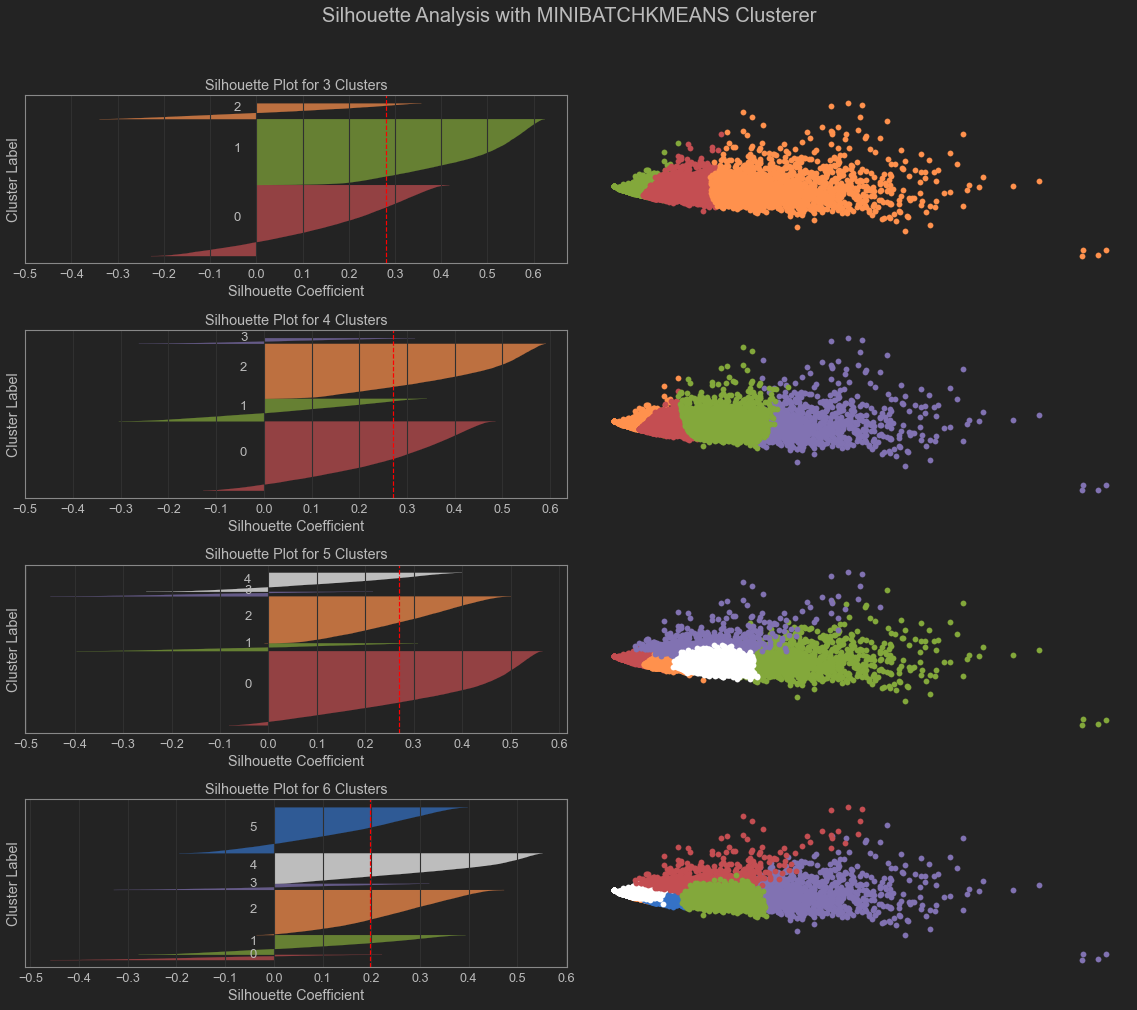

--- silhouette analysis() completed in 132.3804 seconds ---


In [28]:
silhouette_analysis(X2_std_, [3,4,5,6], 'MINIBATCHKMEANS', pca_results_2)

### agglomerative clustering

#### agglomerative-1 (complete/cosine)

In [ ]:
silhouette_analysis(X1_std_, [4,5,6], 'AGGLOMERATIVE-1', pca_results_1)
#silhouette_analysis(X1_std_, [4,5,6], 'AGGLOMERATIVE-1', umap_results_1)

#### agglomerative-2 (ward/euclidean)

In [ ]:
silhouette_analysis(X1_std_, [4,5,6], 'AGGLOMERATIVE-2', pca_results_1)
#silhouette_analysis(X1_std_, [4,5,6], 'AGGLOMERATIVE-2', umap_results_1)

#### agglomerative-3 (average/cosine)

In [ ]:
silhouette_analysis(X1_std_, [4,5,6], 'AGGLOMERATIVE-3', pca_results_1)
#silhouette_analysis(X1_std_, [4,5,6], 'AGGLOMERATIVE-3', umap_results_1)

### gmm

In [ ]:
silhouette_analysis(X1_std_, [4,5,6], 'GMM', pca_results_)
#silhouette_analysis(X1_std_, [4,5,6,7], 'GMM', umap_results_)

## final clustering

In [29]:
# double check input shape
print(X1_std.shape)
print(X2_std.shape)

(206059, 9)
(206059, 7)


In [30]:
print('--- Kmeans Start ---')
time_start = time.time()

# define clustering algorithm
clusterer1 = KMeans(n_clusters=4, n_jobs=4)
clusterer2 = KMeans(n_clusters=3, n_jobs=4)

# determine cluster labels
cluster_labels1 = clusterer1.fit_predict(X1_std)
cluster_labels2 = clusterer2.fit_predict(X2_std)

print(f'--- Completed in {time.time() - time_start} seconds ---')

--- Kmeans Start ---
--- Completed in 10.5064218044281 seconds ---


# CLUSTER EVALUATION
---

## apply labels

In [31]:
# add cluster labels to dataset
df_clustered = dfgrp.copy()
df_clustered['Cluster1'] = cluster_labels1
df_clustered['Cluster2'] = cluster_labels2
df_clustered.head()

,user_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,order_number,order_dow,order_hour,days_elapsed,reord1_log1p,num_items_log1p,order_number_log1p,days_elapsed_log1p,Cluster1,Cluster2
0,1,0,0,0,5,0,0,15,0,0,...,11,2.636364,10.090909,17.272727,1.729239,1.996554,2.484907,2.905410,1,0
1,2,17,0,2,36,0,3,9,0,0,...,14,2.142857,10.571429,14.142857,2.033772,2.703277,2.708050,2.717529,1,2
2,3,6,0,0,38,0,0,3,0,4,...,13,1.384615,16.307692,11.076923,1.654558,2.050171,2.639057,2.491296,1,0
3,4,3,0,2,2,2,0,3,0,0,...,6,4.500000,12.500000,14.166667,0.154151,1.386294,1.945910,2.719100,2,0
4,5,2,0,0,23,0,4,0,0,1,...,5,1.400000,15.000000,9.200000,1.526056,2.322388,1.791759,2.322388,1,0


In [32]:
# check how many clusters assigned
print('--- Unique clusters ---')
print(df_clustered.Cluster1.unique())
print(df_clustered.Cluster2.unique())
print()

# check how many observations in each cluster
print('--- Count per cluster ---')
print(df_clustered.Cluster1.value_counts())
print(df_clustered.Cluster1.value_counts(normalize=True))
print()
print(df_clustered.Cluster2.value_counts())
print(df_clustered.Cluster2.value_counts(normalize=True))


--- Unique clusters ---
[1 2 0 3]
[0 2 1]

--- Count per cluster ---
1    84316
2    75860
0    35986
3     9897
Name: Cluster1, dtype: int64
1    0.409184
2    0.368147
0    0.174639
3    0.048030
Name: Cluster1, dtype: float64

0    106099
2     82360
1     17600
Name: Cluster2, dtype: int64
0    0.514896
2    0.399691
1    0.085412
Name: Cluster2, dtype: float64


## descriptive statistics / box plots

### d4/d16 by Cluster

In [33]:
df_clustered.groupby('Cluster1')[['d4','d16']].describe()

d4                                                            \
            count        mean         std  min    25%    50%    75%     max   
Cluster1                                                                      
0         35986.0   89.875980   67.240944  0.0   41.0   77.0  123.0  1217.0   
1         84316.0   32.372444   26.633305  0.0   14.0   26.0   44.0   338.0   
2         75860.0   10.759768   12.709709  0.0    2.0    7.0   15.0   230.0   
3          9897.0  198.411640  120.137668  0.0  111.0  183.0  264.0  1084.0   

              d16                                                          
            count        mean        std  min   25%    50%    75%     max  
Cluster1                                                                   
0         35986.0   51.742733  34.844960  0.0  29.0   45.0   67.0   498.0  
1         84316.0   17.327494  13.000435  0.0   8.0   14.0   23.0   210.0  
2         75860.0    5.709386   6.711780  0.0   1.0    4.0    8.0   193.0  
3          9897.0  121.384258  69.827432  0.0  75.0  110.0  153.0  1531.0

In [34]:
df_clustered.groupby('Cluster2')[['d4','d16']].describe()

d4                                                           \
             count        mean         std  min   25%    50%    75%     max   
Cluster2                                                                      
0         106099.0   14.487450   16.750704  0.0   4.0   10.0   20.0   331.0   
1          17600.0  166.554261  111.003071  0.0  86.0  148.0  224.0  1217.0   
2          82360.0   51.909288   46.226688  0.0  20.0   39.0   69.0   669.0   

               d16                                                         
             count        mean        std  min   25%   50%    75%     max  
Cluster2                                                                   
0         106099.0    7.626123   8.739668  0.0   2.0   5.0   10.0   278.0  
1          17600.0  100.808807  63.676734  0.0  59.0  88.0  128.0  1531.0  
2          82360.0   28.825814  23.797405  0.0  13.0  23.0   38.0   420.0

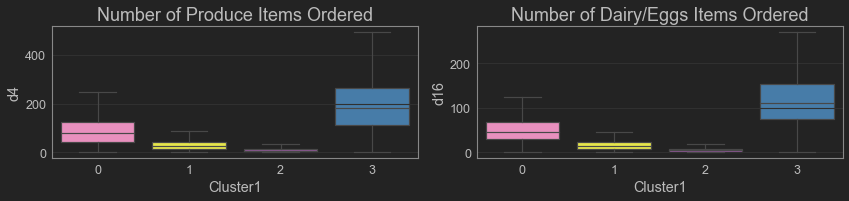

In [35]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,3)

# box plots
plt.subplot(1,2,1)
sns.boxplot(data=df_clustered, x='Cluster1', y='d4', palette='Set1_r', showfliers=False)
plt.title('Number of Produce Items Ordered', fontsize=18)
plt.subplot(1,2,2)
sns.boxplot(data=df_clustered, x='Cluster1', y='d16', palette='Set1_r', showfliers=False)
plt.title('Number of Dairy/Eggs Items Ordered', fontsize=18)

plt.tight_layout()
plt.show()

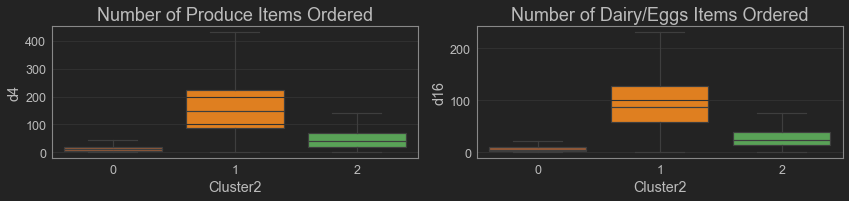

In [36]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,3)

# box plots
plt.subplot(1,2,1)
sns.boxplot(data=df_clustered, x='Cluster2', y='d4', palette='Set1_r', showfliers=False)
plt.title('Number of Produce Items Ordered', fontsize=18)
plt.subplot(1,2,2)
sns.boxplot(data=df_clustered, x='Cluster2', y='d16', palette='Set1_r', showfliers=False)
plt.title('Number of Dairy/Eggs Items Ordered', fontsize=18)

plt.tight_layout()
plt.show()

### num_items/reord1 by Cluster

In [37]:
df_clustered.groupby('Cluster1')[['num_items','reord1']].describe()

num_items                                                      \
             count       mean       std       min       25%        50%   
Cluster1                                                                 
0          35986.0  11.008630  4.016638  1.350000  7.962963  10.651668   
1          84316.0  11.241847  3.775666  2.957746  8.444444  10.714286   
2          75860.0   4.948686  2.357299  0.000000  3.142857   4.750000   
3           9897.0  12.372752  3.449325  3.295775  9.775510  12.266667   

                                 reord1                                \
                75%        max    count      mean       std       min   
Cluster1                                                                
0         13.772727  25.352941  35986.0  6.903730  3.064214  0.318182   
1         13.500000  26.000000  84316.0  4.851914  2.460233  0.000000   
2          6.500000  26.000000  75860.0  1.427270  0.829909  0.000000   
3         14.875000  23.235294   9897.0  9.172495  3.058362  1.130000   

                                                    
               25%       50%        75%        max  
Cluster1                                            
0         4.627202  6.392857   8.666667  23.411765  
1         3.166667  4.250000   5.923077  25.000000  
2         0.777778  1.333333   2.000000   6.000000  
3         6.890000  8.900000  11.255319  21.261905

In [38]:
df_clustered.groupby('Cluster2')[['num_items','reord1']].describe()

num_items                                                             \
             count       mean       std   min       25%        50%        75%   
Cluster2                                                                        
0         106099.0   6.052572  2.977099  0.00  3.750000   5.761905   8.000000   
1          17600.0  12.216014  3.561577  2.61  9.549292  12.051503  14.762218   
2          82360.0  11.956179  3.913466  2.11  9.023256  11.625000  14.546591   

                       reord1                                          \
                max     count      mean       std       min       25%   
Cluster2                                                                
0         26.000000  106099.0  1.914839  1.166577  0.000000  1.000000   
1         25.352941   17600.0  8.733272  3.084713  1.130000  6.428571   
2         26.000000   82360.0  6.067465  2.710413  0.318182  4.157484   

                                          
               50%        75%        max  
Cluster2                                  
0         1.750000   2.666667   9.000000  
1         8.381653  10.762107  23.411765  
2         5.500000   7.375000  25.000000

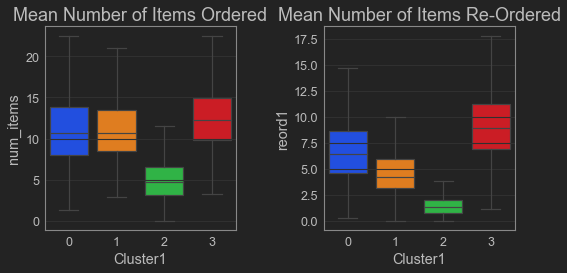

In [39]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# box plots
plt.subplot(1,2,1)
sns.boxplot(data=df_clustered, x='Cluster1', y='num_items', palette='bright', showfliers=False)
plt.title('Mean Number of Items Ordered', fontsize=18)

plt.subplot(1,2,2)
sns.boxplot(data=df_clustered, x='Cluster1', y='reord1', palette='bright', showfliers=False)
plt.title('Mean Number of Items Re-Ordered', fontsize=18)

plt.tight_layout()
plt.show()

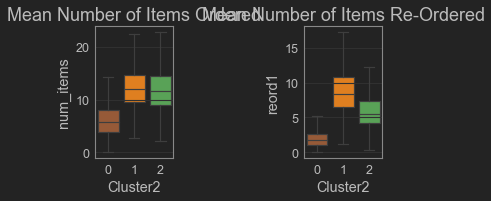

In [40]:
# set figure size
plt.rcParams['figure.figsize'] = (6,3)

# box plots
plt.subplot(1,2,1)
sns.boxplot(data=df_clustered, x='Cluster2', y='num_items', palette='Set1_r', showfliers=False)
plt.title('Mean Number of Items Ordered', fontsize=18)

plt.subplot(1,2,2)
sns.boxplot(data=df_clustered, x='Cluster2', y='reord1', palette='Set1_r', showfliers=False)
plt.title('Mean Number of Items Re-Ordered', fontsize=18)

plt.tight_layout()
plt.show()

### days_elapsed by Cluster

In [41]:
df_clustered.groupby('Cluster1')['days_elapsed'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster1,,,,,,,,
0,35986.0,9.518840,3.486100,0.292929,7.000000,9.189189,11.740741,26.222222
1,84316.0,14.348416,5.191492,0.000000,10.538462,14.461538,18.142857,30.000000
2,75860.0,15.104860,5.477383,0.000000,11.106673,15.500000,19.375000,30.000000
3,9897.0,5.872545,2.071878,0.230000,4.309524,5.770492,7.217391,16.666667


In [42]:
df_clustered.groupby('Cluster2')['days_elapsed'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster2,,,,,,,,
0,106099.0,14.814944,5.495405,0.00,10.750000,15.157895,19.0,30.0
1,17600.0,6.909965,2.616860,0.23,4.986254,6.730249,8.5,22.0
2,82360.0,12.904992,5.084049,0.00,9.000000,12.590909,16.5,30.0


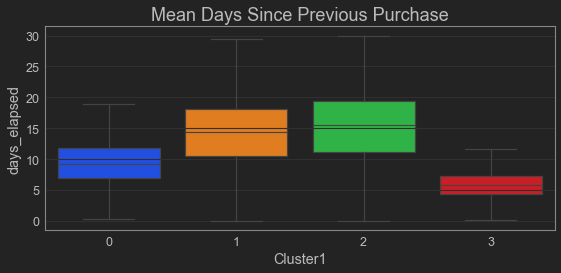

In [43]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# box plots
sns.boxplot(data=df_clustered, x='Cluster1', y='days_elapsed', palette='bright', showfliers=False)
plt.title('Mean Days Since Previous Purchase', fontsize=18)

plt.tight_layout()
plt.show()

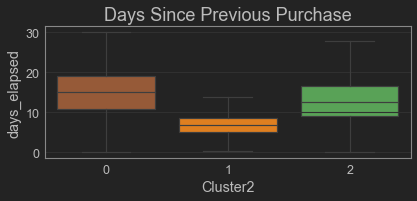

In [44]:
# set figure size
plt.rcParams['figure.figsize'] = (6,3)

# box plots
sns.boxplot(data=df_clustered, x='Cluster2', y='days_elapsed', palette='Set1_r', showfliers=False)
plt.title('Days Since Previous Purchase', fontsize=18)

plt.tight_layout()
plt.show()

### order_number by Cluster

In [45]:
df_clustered.groupby('Cluster1')['order_number'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster1,,,,,,,,
0,35986.0,32.621770,15.186908,7.0,22.0,29.0,39.0,100.0
1,84316.0,11.079416,6.394887,1.0,6.0,10.0,14.0,71.0
2,75860.0,8.992051,7.292218,1.0,5.0,6.0,10.0,100.0
3,9897.0,62.581995,20.743846,20.0,46.0,58.0,77.0,100.0


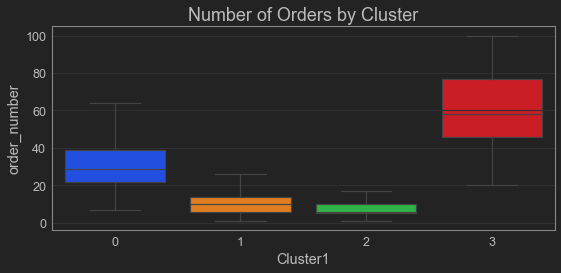

In [46]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# boxplot
sns.boxplot(data=df_clustered, x='Cluster1', y='order_number', palette='bright', showfliers=False)
plt.title('Number of Orders by Cluster', fontsize=18)

plt.tight_layout()
plt.show()

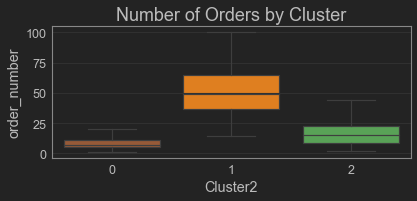

In [47]:
# set figure size
plt.rcParams['figure.figsize'] = (6,3)

# boxplot
sns.boxplot(data=df_clustered, x='Cluster2', y='order_number', palette='Set1_r', showfliers=False)
plt.title('Number of Orders by Cluster', fontsize=18)

plt.tight_layout()
plt.show()

In [48]:
my_data = df_clustered.sample(frac=0.2)
my_data.head()

,user_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,order_number,order_dow,order_hour,days_elapsed,reord1_log1p,num_items_log1p,order_number_log1p,days_elapsed_log1p,Cluster1,Cluster2
40360,40395,6,0,6,2,0,0,13,0,2,...,7,4.428571,13.571429,14.714286,1.145132,2.273598,2.079442,2.754570,1,0
186294,186433,8,0,13,27,0,2,16,0,6,...,10,3.500000,17.300000,22.000000,1.667707,2.493205,2.397895,3.135494,1,2
205453,205604,5,0,2,37,0,7,0,0,15,...,9,1.555556,16.888889,13.555556,1.609438,2.662588,2.302585,2.677973,1,2
187730,187871,13,0,0,18,0,1,0,0,0,...,17,2.294118,15.882353,10.117647,0.830348,1.325670,2.890372,2.408534,2,0
171217,171351,8,0,0,6,0,0,38,0,0,...,23,2.869565,11.739130,11.260870,1.307157,1.724318,3.178054,2.506413,2,0


## density plots

### num_items vs. reord1

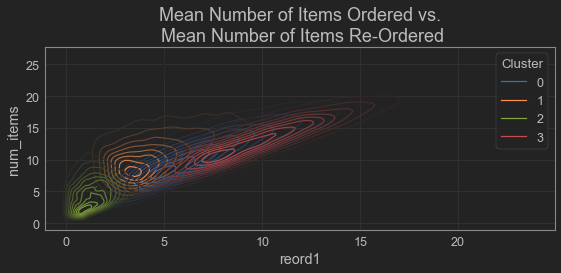

In [49]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster1==0].reord1, my_data[my_data.Cluster1==0].num_items, shade=False, shade_lowest=False, color='b', label='0')
sns.kdeplot(my_data[my_data.Cluster1==1].reord1, my_data[my_data.Cluster1==1].num_items, shade=False, shade_lowest=False, color='y', label='1')
sns.kdeplot(my_data[my_data.Cluster1==2].reord1, my_data[my_data.Cluster1==2].num_items, shade=False, shade_lowest=False, color='g', label='2')
sns.kdeplot(my_data[my_data.Cluster1==3].reord1, my_data[my_data.Cluster1==3].num_items, shade=False, shade_lowest=False, color='r', label='3')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Number of Items Ordered vs.\n Mean Number of Items Re-Ordered', fontsize=18)

plt.tight_layout()
plt.show()

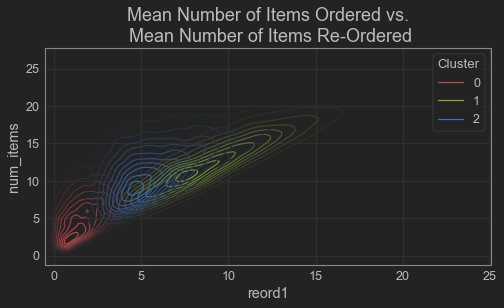

In [50]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster2==0].reord1, my_data[my_data.Cluster2==0].num_items, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster2==1].reord1, my_data[my_data.Cluster2==1].num_items, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster2==2].reord1, my_data[my_data.Cluster2==2].num_items, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster2==3].reord1, my_data[my_data.Cluster2==3].num_items, shade=False, shade_lowest=False, color='y', label='3')
sns.kdeplot(my_data[my_data.Cluster2==4].reord1, my_data[my_data.Cluster2==4].num_items, shade=False, shade_lowest=False, color='w', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Number of Items Ordered vs.\n Mean Number of Items Re-Ordered', fontsize=18)
plt.show()

### days_elapsed vs. num_items

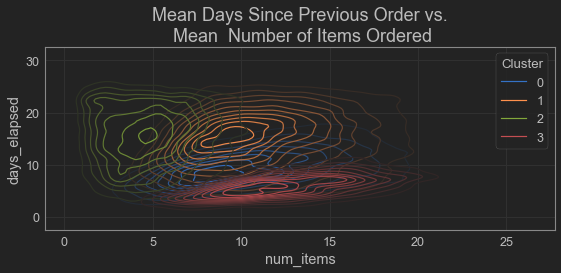

In [51]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster1==0].num_items, my_data[my_data.Cluster1==0].days_elapsed, shade=False, shade_lowest=False, color='b', label='0')
sns.kdeplot(my_data[my_data.Cluster1==1].num_items, my_data[my_data.Cluster1==1].days_elapsed, shade=False, shade_lowest=False, color='y', label='1')
sns.kdeplot(my_data[my_data.Cluster1==2].num_items, my_data[my_data.Cluster1==2].days_elapsed, shade=False, shade_lowest=False, color='g', label='2')
sns.kdeplot(my_data[my_data.Cluster1==3].num_items, my_data[my_data.Cluster1==3].days_elapsed, shade=False, shade_lowest=False, color='r', label='3')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Days Since Previous Order vs.\n Mean  Number of Items Ordered', fontsize=18)

plt.tight_layout()
plt.show()

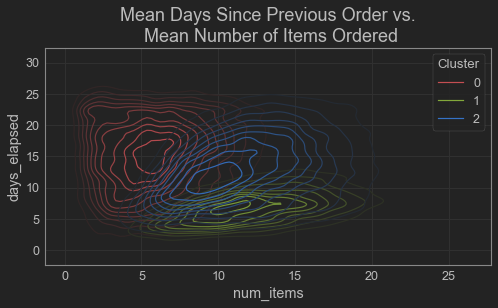

In [52]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster2==0].num_items, my_data[my_data.Cluster2==0].days_elapsed, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster2==1].num_items, my_data[my_data.Cluster2==1].days_elapsed, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster2==2].num_items, my_data[my_data.Cluster2==2].days_elapsed, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster2==3].num_items, my_data[my_data.Cluster2==3].days_elapsed, shade=False, shade_lowest=False, color='y', label='3')
sns.kdeplot(my_data[my_data.Cluster2==4].num_items, my_data[my_data.Cluster2==4].days_elapsed, shade=False, shade_lowest=False, color='w', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Days Since Previous Order vs.\n Mean Number of Items Ordered', fontsize=18)
plt.show()

### days_elapsed vs. reord1

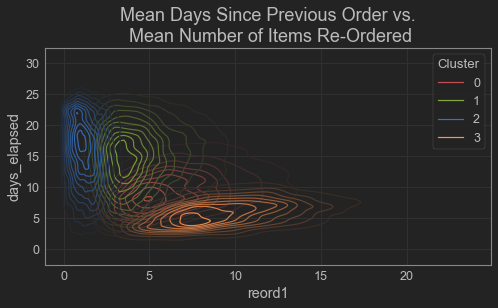

In [53]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster1==0].reord1, my_data[my_data.Cluster1==0].days_elapsed, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster1==1].reord1, my_data[my_data.Cluster1==1].days_elapsed, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster1==2].reord1, my_data[my_data.Cluster1==2].days_elapsed, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster1==3].reord1, my_data[my_data.Cluster1==3].days_elapsed, shade=False, shade_lowest=False, color='y', label='3')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Days Since Previous Order vs.\n Mean Number of Items Re-Ordered', fontsize=18)
plt.show()

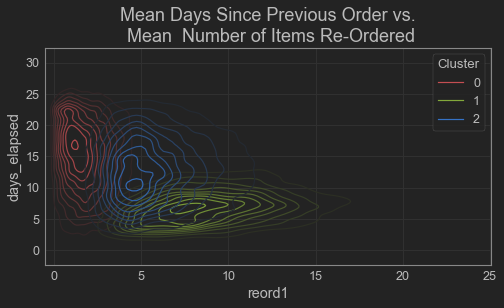

In [54]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster2==0].reord1, my_data[my_data.Cluster2==0].days_elapsed, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster2==1].reord1, my_data[my_data.Cluster2==1].days_elapsed, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster2==2].reord1, my_data[my_data.Cluster2==2].days_elapsed, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster2==3].reord1, my_data[my_data.Cluster2==3].days_elapsed, shade=False, shade_lowest=False, color='y', label='3')
sns.kdeplot(my_data[my_data.Cluster2==4].reord1, my_data[my_data.Cluster2==4].days_elapsed, shade=False, shade_lowest=False, color='w', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Mean Days Since Previous Order vs.\n Mean  Number of Items Re-Ordered', fontsize=18)
plt.show()

### order_number vs. num_items

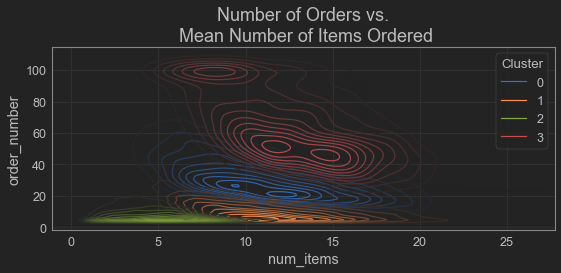

In [55]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster1==0].num_items, my_data[my_data.Cluster1==0].order_number, shade=False, shade_lowest=False, color='b', label='0')
sns.kdeplot(my_data[my_data.Cluster1==1].num_items, my_data[my_data.Cluster1==1].order_number, shade=False, shade_lowest=False, color='y', label='1')
sns.kdeplot(my_data[my_data.Cluster1==2].num_items, my_data[my_data.Cluster1==2].order_number, shade=False, shade_lowest=False, color='g', label='2')
sns.kdeplot(my_data[my_data.Cluster1==3].num_items, my_data[my_data.Cluster1==3].order_number, shade=False, shade_lowest=False, color='r', label='3')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Number of Orders vs.\n Mean Number of Items Ordered', fontsize=18)

plt.tight_layout()
plt.show()

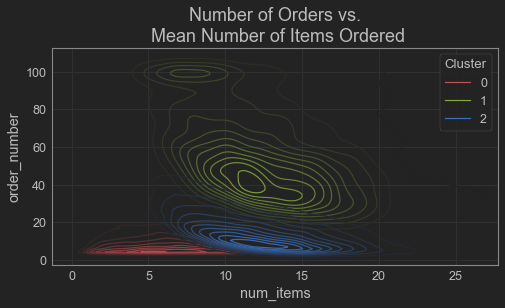

In [56]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster2==0].num_items, my_data[my_data.Cluster2==0].order_number, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster2==1].num_items, my_data[my_data.Cluster2==1].order_number, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster2==2].num_items, my_data[my_data.Cluster2==2].order_number, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster2==3].num_items, my_data[my_data.Cluster2==3].order_number, shade=False, shade_lowest=False, color='y', label='3')
sns.kdeplot(my_data[my_data.Cluster2==4].num_items, my_data[my_data.Cluster2==4].order_number, shade=False, shade_lowest=False, color='w', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Number of Orders vs.\n Mean Number of Items Ordered', fontsize=18)
plt.show()

### order_number vs. reord1

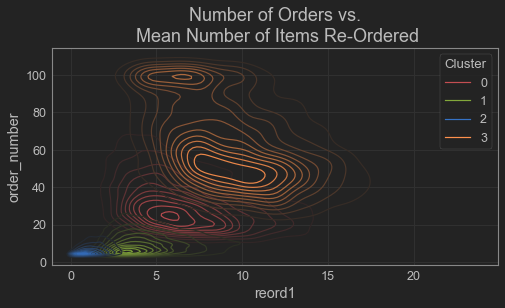

In [57]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster1==0].reord1, my_data[my_data.Cluster1==0].order_number, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster1==1].reord1, my_data[my_data.Cluster1==1].order_number, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster1==2].reord1, my_data[my_data.Cluster1==2].order_number, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster1==3].reord1, my_data[my_data.Cluster1==3].order_number, shade=False, shade_lowest=False, color='y', label='3')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Number of Orders vs.\n Mean Number of Items Re-Ordered', fontsize=18)
plt.show()

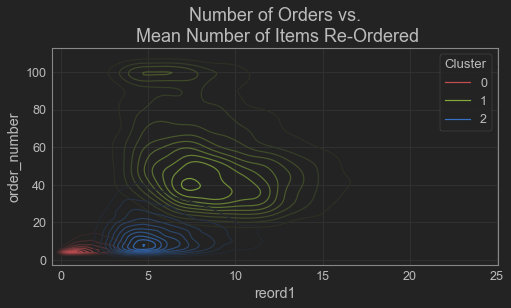

In [58]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster2==0].reord1, my_data[my_data.Cluster2==0].order_number, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster2==1].reord1, my_data[my_data.Cluster2==1].order_number, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster2==2].reord1, my_data[my_data.Cluster2==2].order_number, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster2==3].reord1, my_data[my_data.Cluster2==3].order_number, shade=False, shade_lowest=False, color='y', label='3')
sns.kdeplot(my_data[my_data.Cluster2==4].reord1, my_data[my_data.Cluster2==4].order_number, shade=False, shade_lowest=False, color='w', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Number of Orders vs.\n Mean Number of Items Re-Ordered', fontsize=18)
plt.show()

### order_number vs. days_elapsed

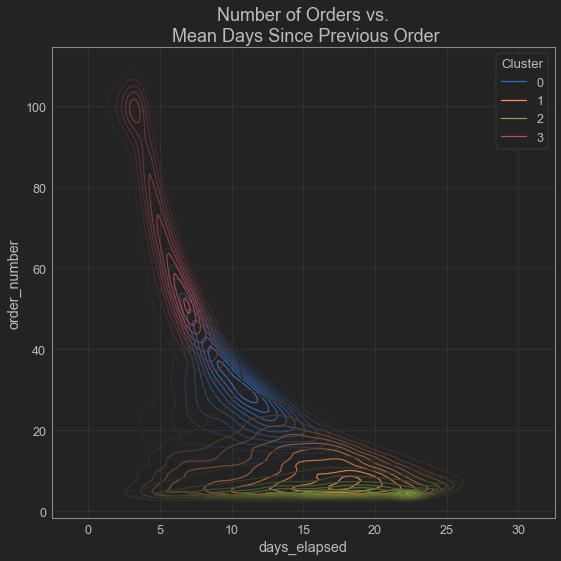

In [59]:
# set figure size
plt.rcParams['figure.figsize'] = (8,8)

# kde plots
sns.kdeplot(my_data[my_data.Cluster1==0].days_elapsed, my_data[my_data.Cluster1==0].order_number, shade=False, shade_lowest=False, color='b', label='0')
sns.kdeplot(my_data[my_data.Cluster1==1].days_elapsed, my_data[my_data.Cluster1==1].order_number, shade=False, shade_lowest=False, color='y', label='1')
sns.kdeplot(my_data[my_data.Cluster1==2].days_elapsed, my_data[my_data.Cluster1==2].order_number, shade=False, shade_lowest=False, color='g', label='2')
sns.kdeplot(my_data[my_data.Cluster1==3].days_elapsed, my_data[my_data.Cluster1==3].order_number, shade=False, shade_lowest=False, color='r', label='3')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Number of Orders vs.\n Mean Days Since Previous Order', fontsize=18)

plt.tight_layout()
plt.show()

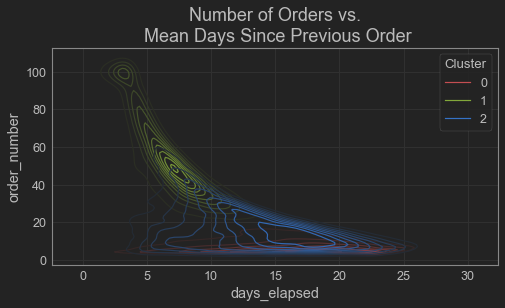

In [60]:
# set figure size
plt.rcParams['figure.figsize'] = (8,4)

# kde plots
sns.kdeplot(my_data[my_data.Cluster2==0].days_elapsed, my_data[my_data.Cluster2==0].order_number, shade=False, shade_lowest=False, color='r', label='0')
sns.kdeplot(my_data[my_data.Cluster2==1].days_elapsed, my_data[my_data.Cluster2==1].order_number, shade=False, shade_lowest=False, color='g', label='1')
sns.kdeplot(my_data[my_data.Cluster2==2].days_elapsed, my_data[my_data.Cluster2==2].order_number, shade=False, shade_lowest=False, color='b', label='2')
sns.kdeplot(my_data[my_data.Cluster2==3].days_elapsed, my_data[my_data.Cluster2==3].order_number, shade=False, shade_lowest=False, color='y', label='3')
sns.kdeplot(my_data[my_data.Cluster2==4].days_elapsed, my_data[my_data.Cluster2==4].order_number, shade=False, shade_lowest=False, color='w', label='4')

# plot labeling options
plt.legend(title='Cluster')
plt.title('Number of Orders vs.\n Mean Days Since Previous Order', fontsize=18)
plt.show()

In [61]:
df_clustered.head()

,user_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,order_number,order_dow,order_hour,days_elapsed,reord1_log1p,num_items_log1p,order_number_log1p,days_elapsed_log1p,Cluster1,Cluster2
0,1,0,0,0,5,0,0,15,0,0,...,11,2.636364,10.090909,17.272727,1.729239,1.996554,2.484907,2.905410,1,0
1,2,17,0,2,36,0,3,9,0,0,...,14,2.142857,10.571429,14.142857,2.033772,2.703277,2.708050,2.717529,1,2
2,3,6,0,0,38,0,0,3,0,4,...,13,1.384615,16.307692,11.076923,1.654558,2.050171,2.639057,2.491296,1,0
3,4,3,0,2,2,2,0,3,0,0,...,6,4.500000,12.500000,14.166667,0.154151,1.386294,1.945910,2.719100,2,0
4,5,2,0,0,23,0,4,0,0,1,...,5,1.400000,15.000000,9.200000,1.526056,2.322388,1.791759,2.322388,1,0


## write to file

In [62]:
#df_clustered.to_csv('instacart_clustered.csv', index=False)

## top departments by cluster

In [63]:
import squarify

df_dept = pd.read_csv('departments.csv')
def lookup_dept_name(x):
    x = int(x[1:])
    return df_dept[df_dept.department_id==x].department.iloc[0]

In [75]:
def agg_dept_cluster(cluster):
    df_tmp = pd.DataFrame(df_clustered[df_clustered.Cluster1==cluster][dept_list].sum()).reset_index()
    df_tmp.columns = ['dept_id','item_count']
    df_tmp = df_tmp.sort_values(by='item_count', ascending=False).reset_index().drop(['index'], axis=1)
    df_tmp['dept'] = df_tmp.dept_id.apply(lookup_dept_name)
    df_tmp['item_percent'] = df_tmp.item_count / df_tmp.item_count.sum()
    return df_tmp

In [65]:
def plot_squarify_dept(cluster):
    
    # set figure parameters
    plt.rcParams['figure.figsize'] = (12,3)
    plt.rcParams['font.size'] = 14

    # define data to plot
    my_data = agg_dept_cluster(cluster)
    my_data.item_percent = my_data.item_percent * 100
    my_data.item_percent = my_data.item_percent.round(2)
    my_data['ranking'] = my_data.index + 1
    my_data['label'] = my_data.ranking.astype(str) + '.' + my_data.dept + '\n' + my_data.item_percent.astype(str) + '%'
    my_data = my_data.head(10)

    # plot treemap
    #square_colors = sns.husl_palette(21)
    square_colors = sns.color_palette('dark',21)
    squarify.plot(sizes=my_data.item_percent, label=my_data.label, color=square_colors, alpha=1.0, pad=True)

    # plot labeling options
    plt.title(f'Top 10 Departments by Items Ordered\nCluster {cluster}', fontsize=24)
    plt.axis('off')
    plt.show()


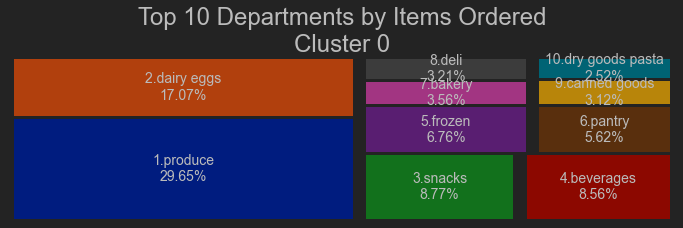

In [76]:
plot_squarify_dept(0)

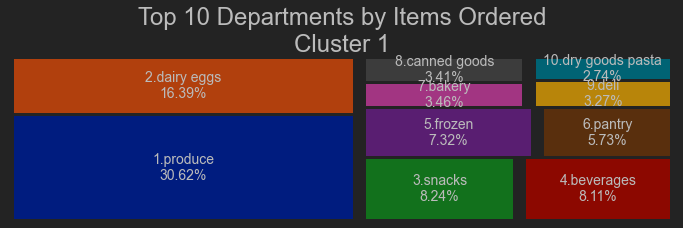

In [77]:
plot_squarify_dept(1)

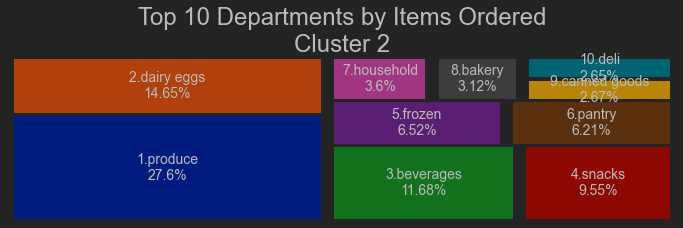

In [78]:
plot_squarify_dept(2)

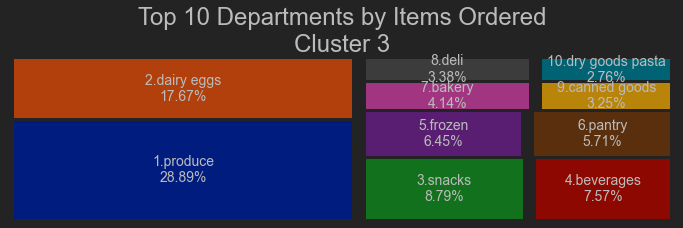

In [79]:
plot_squarify_dept(3)